In [2]:
import pandas as pd
import Nguyen_data_processor as dp

# Import data
data = pd.read_csv('/Users/nguyennguyen/Documents/Clinical Bioinfo/MLAI/BINF-5507-Assignment-2/Data/heart_disease_uci.csv')

# Cleaning data
clean_data = data.copy()

clean_data = dp.remove_missing_columns(clean_data)
clean_data = dp.impute_missing_values(clean_data)
clean_data = dp.remove_duplicates(clean_data)
clean_data = dp.normalize_data(clean_data)
clean_data = dp.remove_redundant_features(clean_data)

print(clean_data.info())

clean_data.to_csv('/Users/nguyennguyen/Documents/Clinical Bioinfo/MLAI/BINF-5507-Assignment-2/Data/cleaned_heart_disease_uci.csv', index = False)


<class 'pandas.core.frame.DataFrame'>
Index: 918 entries, 0 to 919
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       918 non-null    float64
 1   sex       918 non-null    object 
 2   dataset   918 non-null    object 
 3   cp        918 non-null    object 
 4   trestbps  918 non-null    float64
 5   chol      918 non-null    float64
 6   fbs       828 non-null    object 
 7   restecg   916 non-null    object 
 8   thalch    918 non-null    float64
 9   exang     863 non-null    object 
 10  oldpeak   918 non-null    float64
 11  num       918 non-null    float64
dtypes: float64(6), object(6)
memory usage: 93.2+ KB
None


/Users/nguyennguyen/Documents/Clinical Bioinfo/MLAI/BINF-5507-Assignment-2/Script/Nguyen_data_processor.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mean(), inplace = True)


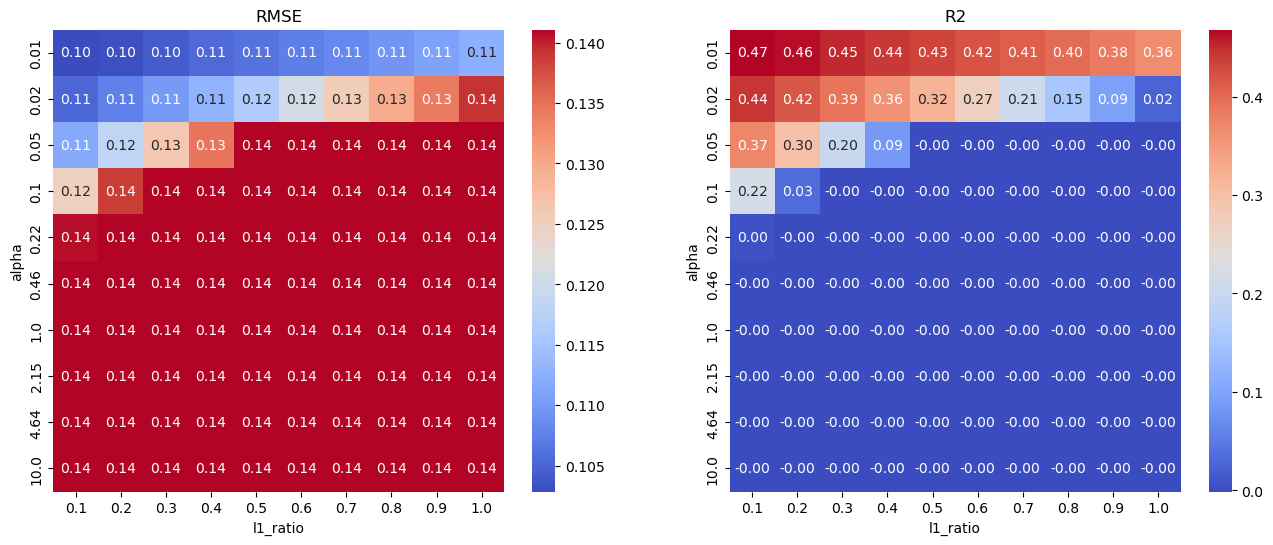

Best alpha and l1_ratio for minimum RMSE: 0.01, 0.1
Best alpha and l1_ratio for maximum R2: 0.01, 0.1


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

# ================================= Preparing model ==============================================
# Drop any rows with NA values
reg_data = clean_data.copy()
reg_data.dropna(inplace = True)

# Split data into features and target
target = reg_data['chol']
features = reg_data.drop(columns = ['chol'])

# if the column is not numeric, encode it (one-hot)
cat_cols = features.select_dtypes(include='object').columns
features = pd.get_dummies(features, columns = cat_cols, prefix = cat_cols)

# Splitting data set for training and testing
x_train, x_test, y_train, y_test = train_test_split(features, target, train_size = 0.8, random_state = 42)


# =================== Fitting model to various alphas and l1_ratios ================================
# Make a list of values for alpha and l1_ratio
alphas = np.logspace(-2,1,10)
l1_ratios = np.linspace(0.1,1,10)

# Create a 2D arrays to store subsequent RMSE and R2 values in, with respect to each combination of alpha and l1-ratio
rmse_values = np.zeros((len(alphas), len(l1_ratios)))
r2_values = np.zeros((len(alphas), len(l1_ratios)))

# Create and fit the model using those 100 combinations of alphas and l1_ratio
for i, alpha_value in enumerate(alphas):
    for j, l1_ratio_value in enumerate(l1_ratios):

        # Fitting ElasticNet model
        reg_model = ElasticNet(alpha=alpha_value, l1_ratio=l1_ratio_value)
        reg_model.fit(x_train, y_train)

        # Predict value and assess model
        y_predict = reg_model.predict(x_test)
        rmse_values[i,j] = np.sqrt(mean_squared_error(y_test, y_predict))
        r2_values[i,j] = r2_score(y_test, y_predict)


# =================================== Visualization ===============================================
fig, axs = plt.subplots(1,2, figsize=(16,6))

# Make rmse heatmap
sns.heatmap(rmse_values, annot=True, fmt=".2f",
            xticklabels=np.round(l1_ratios, 2),
            yticklabels=np.round(alphas, 2), 
            cmap="coolwarm", ax=axs[0])
axs[0].set_title("RMSE") 
axs[0].set_xlabel("l1_ratio")
axs[0].set_ylabel("alpha")

# Make r2 heatmap
sns.heatmap(r2_values, annot=True, fmt=".2f",
            xticklabels=np.round(l1_ratios, 2),
            yticklabels=np.round(alphas, 2), 
            cmap="coolwarm", ax=axs[1])
axs[1].set_title("R2") 
axs[1].set_xlabel("l1_ratio")
axs[1].set_ylabel("alpha")

plt.show()


# =================================== Find best config ===============================================
# Find the indices of the cell with the minimum RMSE
# Use np.argmin() to find the indices of the minimum value in the 2D array, specifying the shape of the array
# First, it flattens the array into 1D dimension:
#       [1,2,3]
#       [4,5,6]     => [1,2,3,4,5,6,7,8,9]
#       [7,8,9]
# Then it finds the minimum value and return the index in the flattened array. In this case, it would be index 0 (value 1)
# It also returns the shape of the original array.
# We then use np.unravel_index() to convert the index to match the original 2D array, returning a tuple of the input flattened index.
#       [1,2,3]
#       [4,5,6]     => [1,2,3,4,5,6,7,8,9]
#       [7,8,9]     =>  0 = [0,0]
min_rmse_idx = np.unravel_index(np.argmin(rmse_values), rmse_values.shape)
# After getting the 2D index for best config, we can extract the value of each axis (alpha and l1_ratio)
alpha_min_rmse = alphas[min_rmse_idx[0]]
l1_ratio_min_rmse = l1_ratios[min_rmse_idx[1]]

# Find the indices of the cell with the maximum R2
max_r2_idx = np.unravel_index(np.argmax(r2_values), r2_values.shape)
alpha_max_r2 = alphas[max_r2_idx[0]]
l1_ratio_max_r2 = l1_ratios[max_r2_idx[1]]

# Print out best config:
print(f"Best alpha and l1_ratio for minimum RMSE: {alpha_min_rmse}, {l1_ratio_min_rmse}")
print(f"Best alpha and l1_ratio for maximum R2: {alpha_max_r2}, {l1_ratio_max_r2}")


In [ ]:
# 2. Classification Models
# Train and evaluate logistic regression and k-NN classifiers to predict heart disease
# presence as a binary classification task.

# Tasks:
# 1. Use accuracy, F1 score, AUROC, and AUPRC as evaluation metrics.
# 2. For logistic regression:
#       Use LogisticRegression. Experiment with varying parameters
#       (penalty and solver) and observe their effects on model coefficients
#       and performance.
# 3. For k-NN:
#       Tune the hyperparameter n_neighbors (e.g., {1, 5, 10}) and compare its
#       impact on evaluation metrics.
# 4. For both models:
#       Plot AUROC and AUPRC curves for the model’s best configuration.